# Dependencies

In [1]:
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
import tensorflow as tf, re, math

# Auxiliar functions

In [2]:
def decode_image(image, HEIGHT, WIDTH, CHANNELS):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example, HEIGHT, WIDTH, CHANNELS):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'], HEIGHT, WIDTH, CHANNELS)
    return image

def load_dataset(filenames, HEIGHT, WIDTH, CHANNELS=3):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(lambda example: read_tfrecord(example, HEIGHT, WIDTH, CHANNELS), num_parallel_calls=AUTO)      
    return dataset

def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()


def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Create TF Records
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def serialize_example(image):
  feature = {
      'image': _bytes_feature(image),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

# Parameters

In [3]:
PATH = '/kaggle/input/monet-ext-data/monet_dataset/'
IMGS = os.listdir(PATH)
SIZE = (len(IMGS) // 5) + 1 # split images into 5 files
IMAGE_SIZE = [256, 256]

print(f'Image samples: {len(IMGS)}')

Image samples: 1367


# Generate TF records

In [4]:
CT = len(IMGS)//SIZE + int(len(IMGS)%SIZE!=0)
for j in range(CT):
    print(); print('Writing TFRecord %i of %i...'%(j,CT))
    CT2 = min(SIZE,len(IMGS)-j*SIZE)
    with tf.io.TFRecordWriter('monet%.2i-%i.tfrec'%(j,CT2)) as writer:
        for k in range(CT2):
            img = cv2.imread(PATH+IMGS[SIZE*j+k])
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 94))[1].tostring()
            name = IMGS[SIZE*j+k].split('.')[0]
            example = serialize_example(img)
            writer.write(example)
            if k%100==0: print(k,', ',end='')


Writing TFRecord 0 of 5...
0 , 100 , 200 , 
Writing TFRecord 1 of 5...
0 , 100 , 200 , 
Writing TFRecord 2 of 5...
0 , 100 , 200 , 
Writing TFRecord 3 of 5...
0 , 100 , 200 , 
Writing TFRecord 4 of 5...
0 , 100 , 200 , 

# Validate created TF records

In [5]:
AUTO = tf.data.experimental.AUTOTUNE
FILENAMES = tf.io.gfile.glob('monet*.tfrec')
print(f'TFRecords files: {FILENAMES}')
print(f'Created image samples: {count_data_items(FILENAMES)}')

TFRecords files: ['./monet04-271.tfrec', './monet02-274.tfrec', './monet00-274.tfrec', './monet01-274.tfrec', './monet03-274.tfrec']
Created image samples: 1367


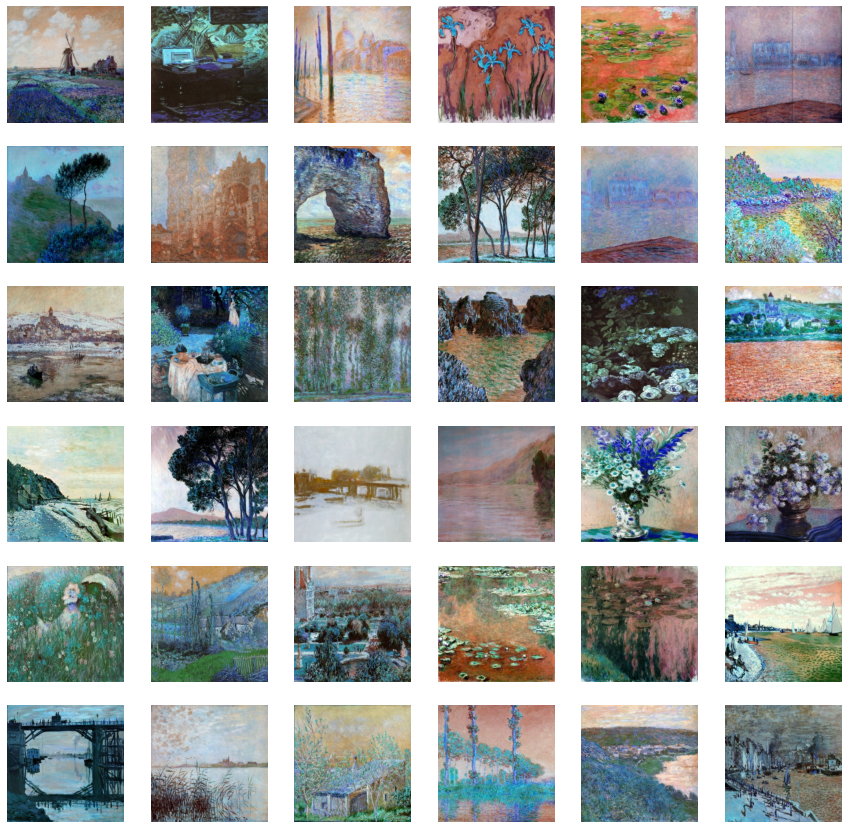

In [6]:
display_samples(load_dataset(FILENAMES, *IMAGE_SIZE).batch(1), 6, 6)